# Loading model

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from model_settings import ms
models_dir = os.path.join(Path().resolve(),'trained_models','trained_models')
models = [f for f in os.listdir(models_dir) if f.find('ipynb')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_10_25 12-23-03 Deep Neural Network asian
1     2024_10_25 15-28-03 Deep Neural Network barrier_price
2     2024_10_25 16-04-54 Deep Neural Network asian


In [2]:
model = models[2]
model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")

0     2024_10_25 15-28-03 Deep Neural Network barrier_price insample.csv
1     2024_10_25 15-28-03 Deep Neural Network barrier_price outsample.csv
2     2024_10_25 15-28-03 Deep Neural Network barrier_price.pkl
3     2024_10_25 15-28-03 Deep Neural Network barrier_price.txt


In [3]:
train_data = pd.read_csv(os.path.join(model_dir,model_files[0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,model_files[1])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'])
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'])
train_data = train_data.set_index('calculation_date')
test_data = test_data.set_index('calculation_date')
model_fit = joblib.load(os.path.join(model_dir,model_files[2]))
model_fit

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'barrier']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['barrier_type_name',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(hidden_layer_sizes=(13,
                                                                                       13,
                                                                                       13),
                                                                   learning_rate='adaptive',
                                                                   max_iter=1000,
                                                                   solver='sgd'))]),
                           transformer=Pipeline(steps=[('StandardScaler',
                                                        StandardScaler())]))

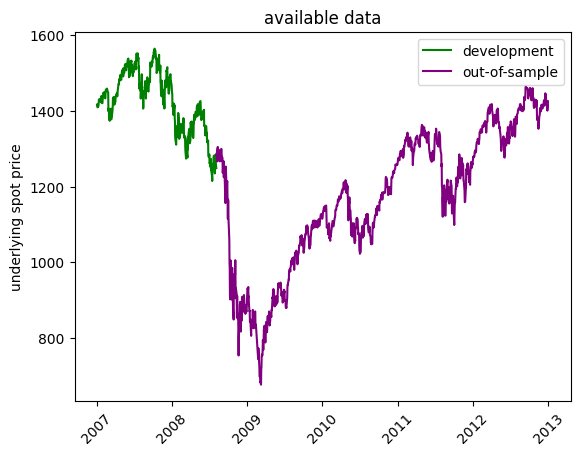

spot_price                float64
strike_price              float64
barrier                   float64
days_to_maturity            int64
updown                     object
outin                      object
w                          object
barrier_type_name          object
rebate                    float64
dividend_rate             float64
risk_free_rate            float64
theta                     float64
kappa                     float64
rho                       float64
eta                       float64
v0                        float64
barrier_price             float64
observed_price            float64
outofsample_target        float64
outofsample_prediction    float64
outofsample_error         float64
30D                       float64
60D                       float64
3M                        float64
6M                        float64
12M                       float64
18M                       float64
24M                       float64
dtype: object

In [4]:
train_spots = train_data['spot_price']
test_spots = test_data['spot_price']
train_dates = pd.Series(train_spots.index)
test_dates = pd.Series(test_spots.index)
plt.figure()
plt.plot(train_spots,color='green',label='development')
plt.plot(test_spots,color='purple',label='out-of-sample')
plt.title('available data')
plt.ylabel('underlying spot price')
plt.xticks(rotation=45)
plt.legend()
plt.show()
root = Path().resolve().parent.parent
original_calibrations = os.path.join(root,ms.calibrations_dir)
file = [f for f in os.listdir(original_calibrations) if f.find('bloomberg_spx')!=-1][0]
ogc = pd.read_csv(os.path.join(original_calibrations,file)).iloc[:,1:]
ogc['date'] = pd.to_datetime(ogc['date'],format='%Y-%m-%d')
ogc = ogc.set_index('date')
ivol_keys = ogc.columns[0:7].tolist()
ivols = ogc[ivol_keys].copy()
test_data = test_data.join(ivols, how='left').dropna()
test_data.dtypes

In [5]:
diff = test_data['outofsample_error']
def compute_RMSE(diff):
    return np.sqrt(np.mean(diff**2))
def compute_MAE(diff):
    return np.mean(np.abs(diff))
test_data['RMSE'] = diff.resample('D').apply(compute_RMSE).dropna()
test_data['MAE'] = diff.resample('D').apply(compute_MAE).dropna()
test_data = test_data[
    [
        'spot_price','dividend_rate','risk_free_rate', 
        'theta', 'kappa', 'rho', 'eta', 'v0',
        '30D', '60D', '3M', '6M', '12M', '18M', '24M',
        'RMSE', 'MAE'
    ]
].drop_duplicates()
test_data

,spot_price,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,30D,60D,3M,6M,12M,18M,24M,RMSE,MAE
2008-08-05,1284.21,0.022633,0.04,0.052443,1.882157,-1.000000,0.160810,0.037092,0.194311,0.200222,0.204812,0.209551,0.211872,0.212937,0.222867,5.054051,3.549254
2008-08-06,1289.26,0.022589,0.04,0.053922,1.781641,-1.000000,0.158199,0.034932,0.189683,0.195553,0.201739,0.208256,0.211348,0.212680,0.222810,4.968396,3.480012
2008-08-07,1266.66,0.022942,0.04,0.054300,1.849474,-1.000000,0.161811,0.039501,0.200517,0.204851,0.210202,0.214721,0.216270,0.216978,0.226751,5.027134,3.548871
2008-08-08,1295.65,0.022417,0.04,0.055041,1.984106,-1.000000,0.165408,0.035764,0.191716,0.199752,0.206432,0.211717,0.214213,0.215521,0.225194,5.180773,3.631399
2008-08-11,1305.09,0.022270,0.04,0.054576,1.687301,-1.000000,0.161471,0.036992,0.193886,0.200391,0.205304,0.211095,0.213004,0.214089,0.223644,4.830385,3.396276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,1425.78,0.022223,0.04,0.045075,1.533653,-0.758727,0.187296,0.021678,0.153299,0.159230,0.163558,0.172875,0.186839,0.196138,0.203063,6.413592,4.431596
2012-12-26,1419.95,0.022330,0.04,0.045965,1.502570,-0.631430,0.230292,0.024230,0.160552,0.165412,0.168617,0.176599,0.189244,0.198177,0.205081,7.183158,4.949361
2012-12-27,1417.38,0.022356,0.04,0.049897,1.254997,-0.471477,0.306944,0.026584,0.167051,0.169555,0.171964,0.178674,0.190965,0.200366,0.207382,8.531916,5.989314
2012-12-28,1401.16,0.022608,0.04,0.054307,1.224926,-0.301439,0.498256,0.031667,0.180012,0.177681,0.178296,0.182266,0.193435,0.201808,0.207643,10.882763,7.737101


# Testing

In [6]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

### testing for the effect of the spot level on pricing accuracy

### unrestricted regression

In [7]:
test_data.dtypes

spot_price        float64
dividend_rate     float64
risk_free_rate    float64
theta             float64
kappa             float64
rho               float64
eta               float64
v0                float64
30D               float64
60D               float64
3M                float64
6M                float64
12M               float64
18M               float64
24M               float64
RMSE              float64
MAE               float64
dtype: object

In [8]:
y = test_data['MAE']
X = test_data[
    [
        'spot_price',
        'theta', 'kappa','rho', 'eta', 'v0',
        '30D', '60D', '3M', '6M', '12M', '18M', '24M',
    ]
].copy()
spot = test_data['spot_price']
underlying_return = spot.values[1:]/spot.values[:-1]-1
underlying_return = np.array([np.nan]+underlying_return.tolist())
X['underlying_return'] = underlying_return
X['ret2'] = underlying_return**2
X = X.iloc[1:]
y = y.iloc[1:]
X.dtypes

spot_price           float64
theta                float64
kappa                float64
rho                  float64
eta                  float64
v0                   float64
30D                  float64
60D                  float64
3M                   float64
6M                   float64
12M                  float64
18M                  float64
24M                  float64
underlying_return    float64
ret2                 float64
dtype: object

In [9]:
Ufit = LinearRegression(fit_intercept=False).fit(X,y)
Uyhat = Ufit.predict(X)
URSS = sum((Uyhat-y)**2)
for i,c in enumerate(Ufit.coef_):
    print(f"b{i}:   {c}")
print(f"R Squared: {Ufit.score(X,y)}")
print(f"URSS: {URSS}")

b0:   0.0009822524612143287
b1:   55.535306672824234
b2:   -0.11697192760725983
b3:   9.368969660942646
b4:   -7.518058600158675
b5:   316.5434798794683
b6:   -423.0898717908791
b7:   114.69770451444951
b8:   261.4768650227144
b9:   -104.74561558833378
b10:   -33.833506731975305
b11:   215.60399405554315
b12:   -58.24843176688022
b13:   -21.7859145213447
b14:   923.7717097306343
R Squared: 0.9212727838558444
URSS: 22893.909787183507


### restricted regression

In [10]:
X = X.iloc[:,1:]
Rfit = LinearRegression(fit_intercept=False).fit(X,y)
Ryhat = Rfit.predict(X)
RRSS = sum((Ryhat-y)**2)
for i,c in enumerate(Rfit.coef_):
    print(f"b{i}:   {c}")
print(f"R Squared: {Rfit.score(X,y)}")
print(f"RRSS: {RRSS}")

b0:   54.47255906590782
b1:   -0.16967118335151143
b2:   8.559533214323604
b3:   -6.149583459687042
b4:   316.8629761334552
b5:   -417.9590927514858
b6:   111.29022420768564
b7:   257.44748576205814
b8:   -115.46077282506468
b9:   -25.59173960830387
b10:   212.8725827929076
b11:   -49.55385531580001
b12:   -21.89149189845295
b13:   929.1767924575596
R Squared: 0.9212069127703922
RRSS: 22913.065128395676


### F-Test

In [11]:
m = len(Ufit.coef_)-len(Rfit.coef_)
n = len(y)
k = len(Ufit.coef_)
dfn = m
dfd = n-k-1
F = ((RRSS-URSS)/dfn)/(URSS/dfd)
alpha = 0.05
critF = stats.f.ppf(1 - alpha, dfn=dfn, dfd=dfd)
print(f"F: {F}, Critical F: {critF}")

F: 0.9145134290963679, Critical F: 3.8499807085087974
